In [41]:
# 1. Install required libraries
!pip install pandas numpy scikit-learn matplotlib seaborn faker

In [42]:
# 2. Import libraries
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from faker import Faker
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import LabelEncoder
from sklearn.linear_model import LogisticRegression
from sklearn.ensemble import RandomForestClassifier
from sklearn.metrics import classification_report, confusion_matrix, roc_auc_score, roc_curve

# 3. Generate synthetic dataset
fake = Faker()
np.random.seed(42)

n = 1000  # Number of transactions
data = []

transaction_types = ["Send Money", "Bill Payment", "Merchant Payment"]
locations = ["Mumbai", "Delhi", "Bangalore", "Hyderabad", "Chennai", "Kolkata"]
devices = ["Android", "iOS"]

for i in range(n):
    amount = round(np.random.uniform(10, 50000), 2)
    time = fake.time(pattern="%H:%M:%S")
    txn_type = np.random.choice(transaction_types)
    location = np.random.choice(locations)
    device = np.random.choice(devices)

    # Fraud logic: High amount at odd hours has higher fraud probability
    hour = int(time.split(":")[0])
    is_fraud = 1 if (amount > 30000 and (hour < 6 or hour > 22)) else np.random.choice([0, 1], p=[0.95, 0.05])

    data.append([
        f"TXN{i+1:05d}",
        fake.user_name() + "@upi",
        amount,
        txn_type,
        location,
        time,
        device,
        is_fraud
    ])

df = pd.DataFrame(data, columns=["TransactionID", "UPI_ID", "Amount", "TransactionType", "Location", "Time", "Device", "IsFraud"])


In [43]:
# Save dataset to CSV (downloadable in Colab)
df.to_csv("synthetic_upi_fraud_dataset.csv", index=False)

print("Sample Data:")
print(df.head())

Sample Data:
  TransactionID            UPI_ID    Amount   TransactionType   Location  \
0      TXN00001       nrivers@upi  18733.26        Send Money  Bangalore   
1      TXN00002  mirandadavis@upi   7809.37  Merchant Payment  Bangalore   
2      TXN00003  nielsenjacob@upi  30059.74  Merchant Payment    Kolkata   
3      TXN00004      ronald59@upi  41623.81      Bill Payment      Delhi   
4      TXN00005  lauriemiller@upi  30877.90      Bill Payment    Kolkata   

       Time   Device  IsFraud  
0  09:58:23      iOS        0  
1  00:14:39  Android        0  
2  19:03:56  Android        1  
3  10:58:25      iOS        1  
4  12:00:41  Android        0  


In [44]:
# 4. Data Preprocessing
df_encoded = df.copy()
label_encoders = {}
for col in ["TransactionType", "Location", "Device"]:
    le = LabelEncoder()
    df_encoded[col] = le.fit_transform(df[col])
    label_encoders[col] = le

# Drop non-numeric columns not used for training
df_encoded = df_encoded.drop(["TransactionID", "UPI_ID", "Time"], axis=1)

# Features and target
X = df_encoded.drop("IsFraud", axis=1)
y = df_encoded["IsFraud"]

# Train-Test split
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

In [45]:
# 5. Train Models

# Logistic Regression
log_reg = LogisticRegression(max_iter=1000)
log_reg.fit(X_train, y_train)
y_pred_lr = log_reg.predict(X_test)

# Random Forest
rf_clf = RandomForestClassifier(n_estimators=100, random_state=42)
rf_clf.fit(X_train, y_train)
y_pred_rf = rf_clf.predict(X_test)


=== Logistic Regression ===
              precision    recall  f1-score   support

           0       0.85      0.99      0.92       169
           1       0.50      0.06      0.11        31

    accuracy                           0.84       200
   macro avg       0.68      0.53      0.51       200
weighted avg       0.80      0.84      0.79       200

ROC AUC: 0.5263409047528155

=== Random Forest ===
              precision    recall  f1-score   support

           0       0.86      0.92      0.89       169
           1       0.30      0.19      0.24        31

    accuracy                           0.81       200
   macro avg       0.58      0.56      0.56       200
weighted avg       0.77      0.81      0.79       200

ROC AUC: 0.5553540752051919


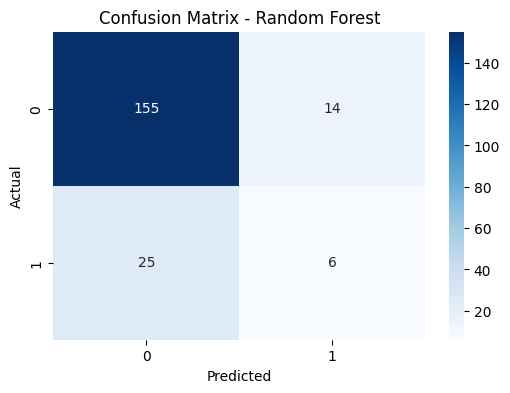

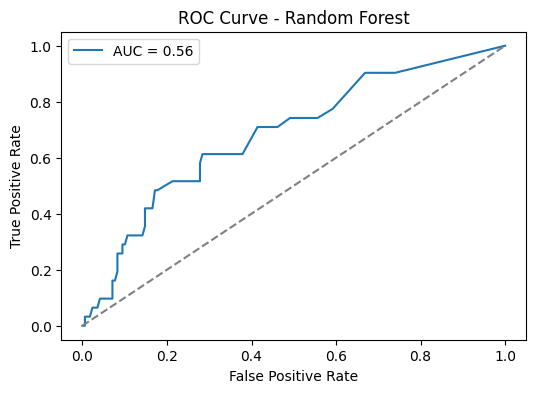

In [46]:
# 6. Evaluation
print("\n=== Logistic Regression ===")
print(classification_report(y_test, y_pred_lr))
print("ROC AUC:", roc_auc_score(y_test, y_pred_lr))

print("\n=== Random Forest ===")
print(classification_report(y_test, y_pred_rf))
print("ROC AUC:", roc_auc_score(y_test, y_pred_rf))

# Confusion Matrix Plot
plt.figure(figsize=(6,4))
sns.heatmap(confusion_matrix(y_test, y_pred_rf), annot=True, fmt="d", cmap="Blues")
plt.title("Confusion Matrix - Random Forest")
plt.xlabel("Predicted")
plt.ylabel("Actual")
plt.show()

# ROC Curve for Random Forest
y_probs_rf = rf_clf.predict_proba(X_test)[:, 1]
fpr, tpr, _ = roc_curve(y_test, y_probs_rf)
plt.figure(figsize=(6,4))
plt.plot(fpr, tpr, label=f"AUC = {roc_auc_score(y_test, y_pred_rf):.2f}")
plt.plot([0,1], [0,1], linestyle="--", color="gray")
plt.xlabel("False Positive Rate")
plt.ylabel("True Positive Rate")
plt.title("ROC Curve - Random Forest")
plt.legend()
plt.show()


In [47]:
# 7. Test with a custom transaction (user input)

# Ask for user input
amount = float(input("Enter Transaction Amount: "))

transaction_type_input = input(f"Enter Transaction Type {list(label_encoders['TransactionType'].classes_)}: ")
location_input = input(f"Enter Location {list(label_encoders['Location'].classes_)}: ")
device_input = input(f"Enter Device {list(label_encoders['Device'].classes_)}: ")

# Convert input to encoded form
transaction_type_encoded = label_encoders["TransactionType"].transform([transaction_type_input])[0]
location_encoded = label_encoders["Location"].transform([location_input])[0]
device_encoded = label_encoders["Device"].transform([device_input])[0]

# Create DataFrame for prediction
sample = pd.DataFrame([{
    "Amount": amount,
    "TransactionType": transaction_type_encoded,
    "Location": location_encoded,
    "Device": device_encoded
}])

# Predict
print("\nSample Transaction Prediction (Random Forest):", rf_clf.predict(sample)[0])

# 8. Also test with first 100 rows of X_test
sample_test = X_test.iloc[0:100]
predictions = rf_clf.predict(sample_test)
print("Predictions on first 100 test samples (0=Legit, 1=Fraud):", predictions)


Enter Transaction Amount: 25000
Enter Transaction Type [np.str_('Bill Payment'), np.str_('Merchant Payment'), np.str_('Send Money')]: Send Money
Enter Location [np.str_('Bangalore'), np.str_('Chennai'), np.str_('Delhi'), np.str_('Hyderabad'), np.str_('Kolkata'), np.str_('Mumbai')]: Delhi
Enter Device [np.str_('Android'), np.str_('iOS')]: iOS

Sample Transaction Prediction (Random Forest): 0
Predictions on first 100 test samples (0=Legit, 1=Fraud): [0 0 0 0 0 0 0 0 0 1 0 0 0 0 0 0 0 0 0 0 0 1 0 0 0 0 1 0 1 0 0 0 0 0 0 0 1
 0 1 0 0 0 0 0 0 1 0 0 0 1 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0
 0 0 0 0 0 1 0 0 0 0 0 0 0 0 0 0 0 1 1 0 0 0 0 0 0 0]
